## Fitbit Data Analysis

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import json
import csv
from datetime import datetime
from collections import defaultdict
from tqdm.notebook import tqdm  # tqdm for Jupyter
from pathlib import Path

# Display versions
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
print("seaborn version:", sns.__version__)

pandas version: 2.2.3
numpy version: 1.26.4
matplotlib version: 3.9.2
seaborn version: 0.13.2


***

### Process Individual Stress Data

In [111]:
def process_stress_json_plot(json_file, csv_file):
    # Load JSON data
    with open(json_file, "r") as f:
        data = json.load(f)

    # Extract stress data
    stress_data = data["body"].get("stress", [])
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame([
        {"date_time": entry["effective_time_frame"]["date_time"], 
         "stress_value": entry["stress"]["value"]}
        for entry in stress_data
    ])
    
    # Convert date_time to datetime format
    df["date_time"] = pd.to_datetime(df["date_time"], format='ISO8601')

    
    # Remove values ≤ 0
    df = df[df["stress_value"] > 0]
    
    # Set time intervals (6-hour bins)
    df["time_bin"] = df["date_time"].dt.floor("6h")

    # Extract day identifier (year-month-day) for counting
    df["day"] = df["time_bin"].dt.date

    # Compute average stress per 6-hour interval
    df_avg = df.groupby(["time_bin", "day"])["stress_value"].mean().reset_index()

    # Count number of 6-hour intervals per day
    day_counts = df_avg["day"].value_counts()

    # Filter out days with less than 2 data points
    valid_days = day_counts[day_counts >= 2].index
    df_avg = df_avg[df_avg["day"].isin(valid_days)]

    # Replace actual dates with sequential day numbers
    df_avg["day_number"] = pd.factorize(df_avg["day"])[0] + 1  # Ensures day numbering starts at 1

    # Map 6-hour intervals to small offsets to spread points horizontally
    time_offsets = {0: 0.0, 6: 0.2, 12: 0.4, 18: 0.6}  # Offsets for 6-hour intervals
    df_avg["hour_offset"] = df_avg["time_bin"].dt.hour.map(time_offsets)

    # Compute x-axis positions
    df_avg["x_position"] = df_avg["day_number"] + df_avg["hour_offset"]

    # Compute overall average stress score
    overall_avg_stress = df_avg["stress_value"].mean()
    print(f"Overall Average Stress Score: {overall_avg_stress:.2f}")

    # Save to CSV (without actual dates)
    df_avg.to_csv(csv_file, index=False)

    # Plot scatter plot
    plt.figure(figsize=(12, 6))
    plt.scatter(df_avg["x_position"], df_avg["stress_value"], color="steelblue", label="Avg Stress", alpha=0.7)

    # Connect points with a thin line
    plt.plot(df_avg["x_position"], df_avg["stress_value"], color="steelblue", linewidth=1, alpha=0.7)

    # Formatting the chart
    plt.xlabel("Day Number")
    plt.ylabel("Average Stress Score")
    plt.title("Average Stress Score per 6-hour Interval")
    plt.ylim(0, 100)  # Fix y-axis scale from 0 to 100

    # Add horizontal reference lines at 25, 75, and 100
    plt.axhline(y=25, color="red", linestyle="--", alpha=0.7, label="Threshold: 25")
    plt.axhline(y=75, color="orange", linestyle="--", alpha=0.7, label="Threshold: 75")
    plt.axhline(y=100, color="green", linestyle="--", alpha=0.7, label="Threshold: 100")

    # Add horizontal line for overall average stress score
    plt.axhline(y=overall_avg_stress, color="purple", linestyle="-", linewidth=1.5, alpha=0.8, label=f"Overall Avg: {overall_avg_stress:.2f}")

    # Add vertical lines at the start of each new day
    unique_days = df_avg["day_number"].unique()
    for day in unique_days:
        plt.axvline(x=day, color="black", linestyle="--", alpha=0.5)

    plt.legend()
    plt.grid(axis="y", linestyle="--", alpha=0.7)  # Grid for readability
    plt.show()


Overall Average Stress Score: 46.94


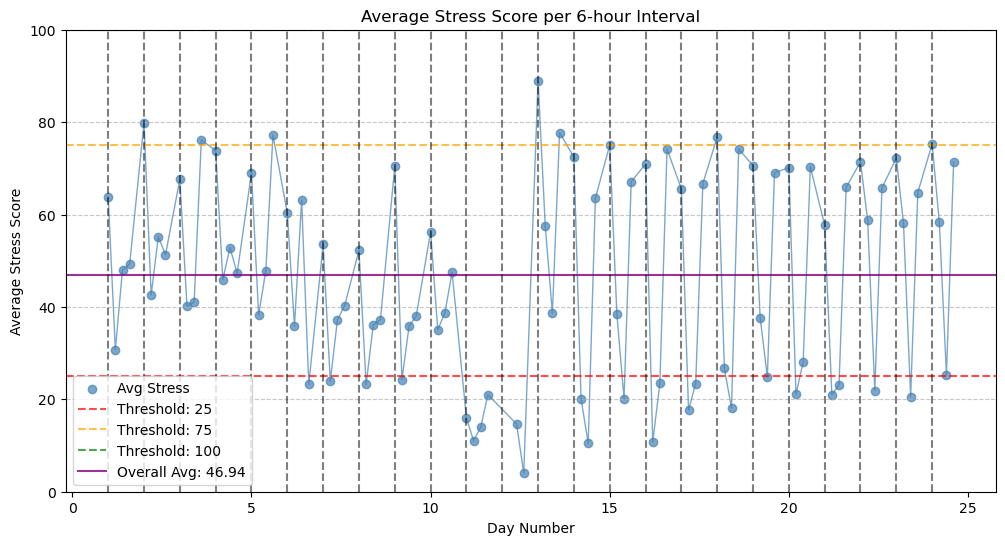

In [112]:
id = 4077
json_file = f"wearable_activity_monitor/stress/garmin_vivosmart5/{id}/{id}_stress.json"
csv_file = f"{id}_stress.csv"
process_stress_json_plot(json_file, csv_file)

***

### Batch Process Stress Data

In [65]:
def process_stress_json(json_file):
    # Load JSON data
    with open(json_file, "r") as f:
        data = json.load(f)

    # Extract stress data
    stress_data = data["body"].get("stress", [])
    
    # Convert to Pandas DataFrame
    df = pd.DataFrame([
        {"date_time": entry["effective_time_frame"]["date_time"], 
         "stress_value": entry["stress"]["value"]}
        for entry in stress_data
    ])
    
    # Convert date_time to datetime format
    df["date_time"] = pd.to_datetime(df["date_time"], format='ISO8601')
    
    # Remove values ≤ 0
    df = df[df["stress_value"] > 0]
    
    # Set time intervals (6-hour bins)
    df["time_bin"] = df["date_time"].dt.floor("6h")

    # Extract day identifier (year-month-day) for counting
    df["day"] = df["time_bin"].dt.date

    # Compute average stress per 6-hour interval
    df_avg = df.groupby(["time_bin", "day"])["stress_value"].mean().reset_index()

    # Count number of 6-hour intervals per day
    day_counts = df_avg["day"].value_counts()

    # Filter out days with less than 2 data points
    valid_days = day_counts[day_counts >= 2].index
    df_avg = df_avg[df_avg["day"].isin(valid_days)]

    # Replace actual dates with sequential day numbers
    df_avg["day_number"] = pd.factorize(df_avg["day"])[0] + 1  # Ensures day numbering starts at 1

    # Compute overall average stress score
    overall_avg_stress = round(df_avg["stress_value"].mean(), 2)
    
    # Count number of valid days used in calculation
    num_valid_days = len(valid_days)
    
    # Return 0 if fewer than 3 valid days were used
    if num_valid_days < 3:
        return np.nan, num_valid_days
    
    return overall_avg_stress, num_valid_days



In [66]:
def process_heart_rate(hr_file):
    if not os.path.isfile(hr_file):
        return None
    with open(hr_file, "r") as file:
        data = json.load(file)
    return [
        entry["heart_rate"]["value"]
        for entry in data.get("body", {}).get("heart_rate", [])
        if entry.get("heart_rate", {}).get("value", None) is not None and entry["heart_rate"]["value"] > 30
    ]

In [67]:
def process_respiratory_rate(rr_file):
    if not os.path.isfile(rr_file):
        return None
    with open(rr_file, "r") as file:
        data = json.load(file)
    return [
        entry["respiratory_rate"]["value"]
        for entry in data.get("body", {}).get("breathing", [])
        if entry.get("respiratory_rate", {}).get("value", None) is not None and entry["respiratory_rate"]["value"] > 5
    ]

In [97]:
def calculate_prq(hr_values, rr_values):
    if not hr_values or not rr_values:
        return None, None, None
    df_hr = pd.DataFrame({"time_bin": pd.date_range(start="00:00", periods=len(hr_values), freq="6h"), "heart_rate": hr_values})
    df_rr = pd.DataFrame({"time_bin": pd.date_range(start="00:00", periods=len(rr_values), freq="6h"), "respiratory_rate": rr_values})
    df_prq = pd.merge(df_hr, df_rr, on="time_bin", how="inner")
    df_prq["PRQ"] = df_prq["heart_rate"] / df_prq["respiratory_rate"]
    return round(df_prq["PRQ"].mean(), 2), round(df_prq["heart_rate"].mean(), 2), round(df_prq["respiratory_rate"].mean(), 2)


In [2]:
def get_sleep_statistics(json_path):
    """
    Extracts sleep statistics from a given JSON file.

    Parameters:
    - json_path: Path to the JSON file.

    Returns:
    - total_days: Total number of unique days in the dataset.
    - avg_awake: Average time spent in Awake stage (minutes).
    - avg_light: Average time spent in Light stage (minutes).
    - avg_rem: Average time spent in REM stage (minutes).
    - avg_deep: Average time spent in Deep stage (minutes).
    """
    import json

    with open(json_path, "r") as file:
        data = json.load(file)

    sleep_data = data["body"]["sleep"]

    start_times = []
    durations = []
    stages = []

    for entry in sleep_data:
        stage = entry["sleep_stage_state"]
        start_time = entry["sleep_stage_time_frame"]["time_interval"]["start_date_time"]
        end_time = entry["sleep_stage_time_frame"]["time_interval"]["end_date_time"]

        start_dt = pd.to_datetime(start_time)
        end_dt = pd.to_datetime(end_time)
        duration = (end_dt - start_dt).total_seconds() / 60  

        stages.append(stage)
        start_times.append(start_dt.date())
        durations.append(duration)

    df = pd.DataFrame({"date": start_times, "sleep_stage": stages, "duration": durations})
    df.to_csv("sleep_data.csv")
    
    total_days = df["date"].nunique()
    avg_durations = df.groupby("sleep_stage")["duration"].mean().to_dict()

    avg_awake = avg_durations.get("awake", 0.0)
    avg_light = avg_durations.get("light", 0.0)
    avg_rem = avg_durations.get("rem", 0.0)
    avg_deep = avg_durations.get("deep", 0.0)

    return total_days, avg_awake, avg_light, avg_rem, avg_deep


In [3]:
file = "wearable_activity_monitor/sleep/garmin_vivosmart5/1023/1023_sleep.json"
get_sleep_statistics(file)

(12, 18.743243243243242, 15.546052631578947, 18.3, 15.370967741935484)

In [8]:
import json
import pandas as pd
from datetime import datetime, timedelta

# File path
file_path = "wearable_activity_monitor/sleep/garmin_vivosmart5/1023/1023_sleep.json"

# Load the JSON data from file
with open(file_path, "r") as file:
    data = json.load(file)

# Function to compute sleep metrics by night and return a DataFrame
def calculate_sleep_metrics_per_night(data):
    sleep_stages = data["body"]["sleep"]
    
    # Dictionary to store sleep data per night
    sleep_data_by_night = {}

    for stage in sleep_stages:
        state = stage["sleep_stage_state"]
        start_time = datetime.fromisoformat(stage["sleep_stage_time_frame"]["time_interval"]["start_date_time"].replace("Z", ""))
        end_time = datetime.fromisoformat(stage["sleep_stage_time_frame"]["time_interval"]["end_date_time"].replace("Z", ""))
        
        duration = (end_time - start_time).total_seconds() / 60  # Convert to minutes
        
        # Determine the "sleep night"
        if start_time.hour >= 18:  # If sleep starts in the evening (after 6 PM)
            night = start_time.date()
        else:  # If sleep happens in the early morning (after midnight but before noon)
            night = (start_time - timedelta(days=1)).date()

        # Initialize dictionary for that night if it does not exist
        if night not in sleep_data_by_night:
            sleep_data_by_night[night] = {
                "Total Sleep (min)": 0,
                "Deep Sleep (min)": 0,
                "REM Sleep (min)": 0
            }

        # Add duration to total sleep (excluding awake)
        if state != "awake":
            sleep_data_by_night[night]["Total Sleep (min)"] += duration

        # Add to specific sleep stage
        if state == "deep":
            sleep_data_by_night[night]["Deep Sleep (min)"] += duration
        elif state == "rem":
            sleep_data_by_night[night]["REM Sleep (min)"] += duration  # <-- Fixed Here

    # Convert to Pandas DataFrame
    df = pd.DataFrame.from_dict(sleep_data_by_night, orient="index").reset_index()
    df.rename(columns={"index": "Sleep Night"}, inplace=True)

    # Calculate %REM and %Deep
    df["% REM Sleep"] = (df["REM Sleep (min)"] / df["Total Sleep (min)"]) * 100
    df["% Deep Sleep"] = (df["Deep Sleep (min)"] / df["Total Sleep (min)"]) * 100

    # Compute the average %REM and %Deep over multiple nights
    avg_rem = df["% REM Sleep"].mean()
    avg_deep = df["% Deep Sleep"].mean()

    return df, avg_rem, avg_deep

# Compute and display sleep metrics
df_sleep, avg_rem, avg_deep = calculate_sleep_metrics_per_night(data)

# Display results
print(f"Average % REM Sleep: {avg_rem:.2f}%")
print(f"Average % Deep Sleep: {avg_deep:.2f}%")
df_sleep


Average % REM Sleep: 17.11%
Average % Deep Sleep: 23.77%


,Sleep Night,Total Sleep (min),Deep Sleep (min),REM Sleep (min),% REM Sleep,% Deep Sleep
0,2023-08-30,279.0,75.0,0.0,0.000000,26.881720
1,2023-08-31,357.0,71.0,74.0,20.728291,19.887955
2,2023-09-01,403.0,88.0,91.0,22.580645,21.836228
3,2023-09-02,261.0,24.0,55.0,21.072797,9.195402
4,2023-09-03,451.0,70.0,139.0,30.820399,15.521064
5,2023-09-04,244.0,43.0,18.0,7.377049,17.622951
6,2023-09-05,313.0,98.0,62.0,19.808307,31.309904
7,2023-09-06,303.0,66.0,33.0,10.891089,21.782178
8,2023-09-07,461.0,144.0,90.0,19.522777,31.236443
9,2023-09-08,294.0,165.0,19.0,6.462585,56.122449


In [30]:
import json
import pandas as pd
from datetime import datetime, timedelta

def calculate_sleep_metrics_per_night(data):
    sleep_stages = data["body"]["sleep"]
    
    # Dictionary to store sleep data per night
    sleep_data_by_night = {}

    for stage in sleep_stages:
        state = stage["sleep_stage_state"].lower()
        start_time = datetime.fromisoformat(stage["sleep_stage_time_frame"]["time_interval"]["start_date_time"].replace("Z", ""))
        end_time = datetime.fromisoformat(stage["sleep_stage_time_frame"]["time_interval"]["end_date_time"].replace("Z", ""))
        
        duration = (end_time - start_time).total_seconds() / 60  # Convert to minutes
        
        # Determine the "sleep night"
        if start_time.hour >= 18:  # If sleep starts in the evening (after 6 PM)
            night = start_time.date()
        else:  # If sleep happens in the early morning (after midnight but before noon)
            night = (start_time - timedelta(days=1)).date()

        # Initialize dictionary for that night if it does not exist
        if night not in sleep_data_by_night:
            sleep_data_by_night[night] = {
                "Total Sleep (min)": 0,
                "Deep Sleep (min)": 0,
                "REM Sleep (min)": 0,
                "REM_latency": None,
                "Sleep_Ratio": None,
                "Sleep_Onset": None,
                "First_REM": None
            }

        # Add duration to total sleep (excluding awake)
        if state != "awake":
            sleep_data_by_night[night]["Total Sleep (min)"] += duration

        # Add to specific sleep stage
        if state == "deep":
            sleep_data_by_night[night]["Deep Sleep (min)"] += duration
        elif state == "rem":
            sleep_data_by_night[night]["REM Sleep (min)"] += duration  

        # Capture sleep onset (first non-awake stage)
        if sleep_data_by_night[night]["Sleep_Onset"] is None and state != "awake":
            sleep_data_by_night[night]["Sleep_Onset"] = start_time

        # Capture first REM sleep occurrence
        if sleep_data_by_night[night]["First_REM"] is None and state == "rem":
            sleep_data_by_night[night]["First_REM"] = start_time

    # Post-processing to compute REM latency and Sleep Ratio
    for night, values in sleep_data_by_night.items():
        if values["Sleep_Onset"] and values["First_REM"]:
            values["REM_latency"] = (values["First_REM"] - values["Sleep_Onset"]).total_seconds() / 60
        if values["Deep Sleep (min)"] > 0:
            values["Sleep_Ratio"] = values["REM Sleep (min)"] / values["Deep Sleep (min)"]

    # Convert to Pandas DataFrame
    df = pd.DataFrame.from_dict(sleep_data_by_night, orient="index").reset_index()
    df.rename(columns={"index": "Sleep_Night"}, inplace=True)

    # Standardize column names for consistency
    column_map = {
        "Total Sleep (min)": "Total_Sleep_(min)",
        "Deep Sleep (min)": "Deep_Sleep_(min)",
        "REM Sleep (min)": "REM_Sleep_(min)",
        "REM_latency": "REM_Latency",
        "Sleep_Ratio": "Sleep_Ratio",
        "Sleep_Onset": "Sleep_Onset",
        "First_REM": "First_REM"
    }
    df.rename(columns=column_map, inplace=True)

    # Ensure required columns exist
    required_columns = set(column_map.values())
    missing_columns = required_columns - set(df.columns)
    if missing_columns:
        raise ValueError(f"Missing required columns: {missing_columns}")

    # Calculate %REM and %Deep
    df["% REM Sleep"] = (df["REM_Sleep_(min)"] / df["Total_Sleep_(min)"]) * 100
    df["% Deep Sleep"] = (df["Deep_Sleep_(min)"] / df["Total_Sleep_(min)"]) * 100

    # Compute the required averages
    percent_rem = df["% REM Sleep"].mean()
    percent_deep = df["% Deep Sleep"].mean()
    sleep_ratio = df["Sleep_Ratio"].mean()
    rem_latency = df["REM_Latency"].mean()

    return df, percent_rem, percent_deep, sleep_ratio, rem_latency


In [44]:
def calculate_sleep_metrics_per_night(data):
    sleep_stages = data["body"]["sleep"]
    
    # Dictionary to store sleep data per night
    sleep_data_by_night = {}

    for stage in sleep_stages:
        state = stage["sleep_stage_state"].lower()
        start_time = datetime.fromisoformat(stage["sleep_stage_time_frame"]["time_interval"]["start_date_time"].replace("Z", ""))
        end_time = datetime.fromisoformat(stage["sleep_stage_time_frame"]["time_interval"]["end_date_time"].replace("Z", ""))
        
        duration = (end_time - start_time).total_seconds() / 60  # Convert to minutes
        
        # Determine the "sleep night"
        if start_time.hour >= 18:  # If sleep starts in the evening (after 6 PM)
            night = start_time.date()
        else:  # If sleep happens in the early morning (after midnight but before noon)
            night = (start_time - timedelta(days=1)).date()

        # Initialize dictionary for that night if it does not exist
        if night not in sleep_data_by_night:
            sleep_data_by_night[night] = {
                "Total Sleep (min)": 0,
                "Deep Sleep (min)": 0,
                "REM Sleep (min)": 0,
                "REM_latency": None,
                "Sleep_Ratio": None,
                "Sleep_Onset": None,
                "First_REM": None
            }

        # Add duration to total sleep (excluding awake)
        if state != "awake":
            sleep_data_by_night[night]["Total Sleep (min)"] += duration

        # Add to specific sleep stage
        if state == "deep":
            sleep_data_by_night[night]["Deep Sleep (min)"] += duration
        elif state == "rem":
            sleep_data_by_night[night]["REM Sleep (min)"] += duration  

        # Capture sleep onset (first non-awake stage)
        if sleep_data_by_night[night]["Sleep_Onset"] is None and state != "awake":
            sleep_data_by_night[night]["Sleep_Onset"] = start_time

        # Capture first REM sleep occurrence
        if sleep_data_by_night[night]["First_REM"] is None and state == "rem":
            sleep_data_by_night[night]["First_REM"] = start_time

    # Post-processing to compute REM latency and Sleep Ratio
    total_sleep_ratio = 0
    total_rem_latency = 0
    count = 0

    for night, values in sleep_data_by_night.items():
        if values["Sleep_Onset"] and values["First_REM"]:
            values["REM_latency"] = (values["First_REM"] - values["Sleep_Onset"]).total_seconds() / 60
        if values["Deep Sleep (min)"] > 0 and values["REM Sleep (min)"] > 0:
            values["Sleep_Ratio"] = values["REM Sleep (min)"] / values["Deep Sleep (min)"]
        else:
            values["Sleep_Ratio"] = None

        # Exclude None values in calculations
        if values["Sleep_Ratio"] is not None:
            total_sleep_ratio += values["Sleep_Ratio"]
            count += 1
        if values["REM_latency"] is not None:
            total_rem_latency += values["REM_latency"]

    # Calculate averages for REM, Deep, Sleep Ratio, and REM Latency
    total_sleep = sum(values["Total Sleep (min)"] for values in sleep_data_by_night.values())
    if total_sleep > 0:
        percent_rem = sum(values["REM Sleep (min)"] for values in sleep_data_by_night.values()) / total_sleep * 100
        percent_deep = sum(values["Deep Sleep (min)"] for values in sleep_data_by_night.values()) / total_sleep * 100
    else:
        percent_rem = percent_deep = 0  # If no sleep data, set to 0

    sleep_ratio = total_sleep_ratio / count if count > 0 else 0
    rem_latency = total_rem_latency / count if count > 0 else 0

    return percent_rem, percent_deep, sleep_ratio, rem_latency


In [45]:
# Example usage
file_path = "wearable_activity_monitor/sleep/garmin_vivosmart5/7274/7274_sleep.json"
with open(file_path, 'r') as f:
    data = json.load(f)

percent_rem, percent_deep, sleep_ratio, rem_latency = calculate_sleep_metrics_per_night(data)

# Display results
print(f"Average % REM Sleep: {percent_rem:.2f}%")
print(f"Average % Deep Sleep: {percent_deep:.2f}%")
print(f"Average Sleep Ratio (REM/Deep): {sleep_ratio:.2f}")
print(f"Average REM Latency (min): {rem_latency:.2f}")



Average % REM Sleep: 31.07%
Average % Deep Sleep: 22.51%
Average Sleep Ratio (REM/Deep): 2.08
Average REM Latency (min): 173.09


In [46]:
import os
import json
import pandas as pd
from tqdm import tqdm  # Import tqdm for progress bar

def update_sleep_metrics(measurements_file, sleep_data_folder):
    # Load the measurements file (CSV with participant data)
    measurements_df = pd.read_csv(measurements_file)
    
    # Initialize an empty list to store the results
    all_results = []
    
    # Loop through each participant folder in the sleep data folder with a progress bar
    participant_folders = [f for f in os.listdir(sleep_data_folder) if os.path.isdir(os.path.join(sleep_data_folder, f))]
    for participant_folder in tqdm(participant_folders, desc="Processing Participants", unit="participant"):
        participant_folder_path = os.path.join(sleep_data_folder, participant_folder)
        
        # Look for JSON files within the participant's folder
        json_files = [f for f in os.listdir(participant_folder_path) if f.endswith('.json')]
        
        for json_file in json_files:
            json_file_path = os.path.join(participant_folder_path, json_file)
            
            # Load the sleep data from the JSON file
            with open(json_file_path, 'r') as f:
                sleep_data = json.load(f)
            
            # Calculate sleep metrics for this participant using the modified function
            percent_rem, percent_deep, sleep_ratio, rem_latency = calculate_sleep_metrics_per_night(sleep_data)
            
            # Store the results, adding the participant ID and file name for reference
            results = {
                'Participant ID': participant_folder,
                'JSON File': json_file,
                'Percent REM': percent_rem,
                'Percent Deep': percent_deep,
                'Sleep Ratio': sleep_ratio,
                'REM Latency': rem_latency
            }
            
            # Append the results for this participant to the all_results list
            all_results.append(results)
    
    # Convert the results into a DataFrame
    final_df = pd.DataFrame(all_results)

    # Save the final DataFrame to a CSV file
    final_df.to_csv('final_sleep_metrics.csv', index=False)

    print("Batch processing complete. Results saved to 'final_sleep_metrics.csv'.")

# Example usage:
measurements_file = 'extracted_data/measurements.csv'
sleep_data_folder = 'wearable_activity_monitor/sleep/garmin_vivosmart5'
update_sleep_metrics(measurements_file, sleep_data_folder)


Processing Participants: 100%|███████| 905/905 [05:52<00:00,  2.56participant/s]

Batch processing complete. Results saved to 'final_sleep_metrics.csv'.


In [103]:
def process_wearable_data(base_dir, summary_csv):
    
    participant_data = {}
    
    stress_dir = os.path.join(base_dir, "stress/garmin_vivosmart5/")
    sleep_dir = os.path.join(base_dir, "sleep/garmin_vivosmart5/")
    hr_dir = os.path.join(base_dir, "heart_rate/garmin_vivosmart5/")
    rr_dir = os.path.join(base_dir, "respiratory_rate/garmin_vivosmart5/")
    
    subfolders = sorted([f for f in os.listdir(stress_dir) if os.path.isdir(os.path.join(stress_dir, f))], key=int)

    for subfolder in tqdm(subfolders, desc="Processing wearable & sleep data"):
        # --- Extract stress data ---
        stress_file = os.path.join(stress_dir, subfolder, f"{subfolder}_stress.json")
        avg_stress, num_valid_days = process_stress_json(stress_file) if os.path.isfile(stress_file) else (None, None)
        
        # --- Extract heart rate & respiratory rate data ---
        hr_file = os.path.join(hr_dir, subfolder, f"{subfolder}_heartrate.json")
        rr_file = os.path.join(rr_dir, subfolder, f"{subfolder}_respiratoryrate.json")
        
        hr_values = process_heart_rate(hr_file)
        rr_values = process_respiratory_rate(rr_file)
        avg_prq, avg_hr, avg_rr = calculate_prq(hr_values, rr_values)
        
        # --- Extract sleep data ---
        sleep_file = os.path.join(sleep_dir, subfolder, f"{subfolder}_sleep.json")
        if os.path.isfile(sleep_file):
            total_days, avg_awake, avg_light, avg_rem, avg_deep = get_sleep_statistics(sleep_file)
        else:
            total_days, avg_awake, avg_light, avg_rem, avg_deep = (None, None, None, None, None)

        # Store participant data
        participant_data[subfolder] = {
            "participant_id": subfolder,
            "avg_stress": avg_stress,
            "valid_stress_days": num_valid_days,
            "avg_PRQ": avg_prq,
            "avg_HR": avg_hr,
            "avg_RR": avg_rr,
            "total_sleep_days": total_days,
            "avg_awake": avg_awake,
            "avg_light": avg_light,
            "avg_rem": avg_rem,
            "avg_deep": avg_deep
        }

    # --- Convert to DataFrame ---
    df_summary = pd.DataFrame.from_dict(participant_data, orient="index")
    df_summary.set_index("participant_id", inplace=True)

    # --- Round all numeric values to 2 decimal places ---
    df_summary = df_summary.round(2)

    # --- Overwrite the CSV file ---
    df_summary.to_csv(summary_csv)
    print(f"Final summary saved to {summary_csv}")



In [104]:
# Run Function
base_directory = "wearable_activity_monitor"
summary_csv_path = "extracted_data/fitbit_data.csv"
process_wearable_data(base_directory, summary_csv_path)

Processing wearable & sleep data: 100%|███████| 904/904 [02:41<00:00,  5.61it/s]

Final summary saved to extracted_data/fitbit_data.csv


In [105]:
def plot_distributions(summary_csv):
    """
    Plots the distributions of avg_stress, avg_HR, avg_RR, and avg_PRQ,
    with a solid red vertical line representing the mean of each distribution.
    
    Parameters:
    - summary_csv: Path to the CSV file containing participant summary data.
    """
    # Load the dataset
    df = pd.read_csv(summary_csv)

    # Set up the figure with subplots (2 rows, 3 columns)
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    axes = axes.flatten()  # Flatten the 2D array for easy iteration

    # Define the variables to plot
    variables = ["avg_stress", "avg_HR", "avg_RR", "avg_PRQ", "avg_rem", "avg_deep"]
    titles = ["Average Stress Score", "Average Heart Rate", "Average Respiratory Rate",
              "Average PRQ", "Average REM", "Average DeepSleep"]

    # Plot histograms for each variable
    for i, var in enumerate(variables):
        if var in df.columns:
            sns.histplot(df[var].dropna(), kde=True, bins=30, ax=axes[i], color="royalblue")
            mean_value = df[var].mean()
            axes[i].axvline(mean_value, color='red', linestyle='-', linewidth=2)  # Add vertical line
            axes[i].set_title(titles[i], fontsize=14)
            axes[i].set_xlabel(var, fontsize=12)
            axes[i].set_ylabel("Count", fontsize=12)
            axes[i].grid(True, linestyle="--", alpha=0.6)

    # Remove empty subplot if there are less than 6 plots
    for j in range(len(variables), len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout()
    plt.show()


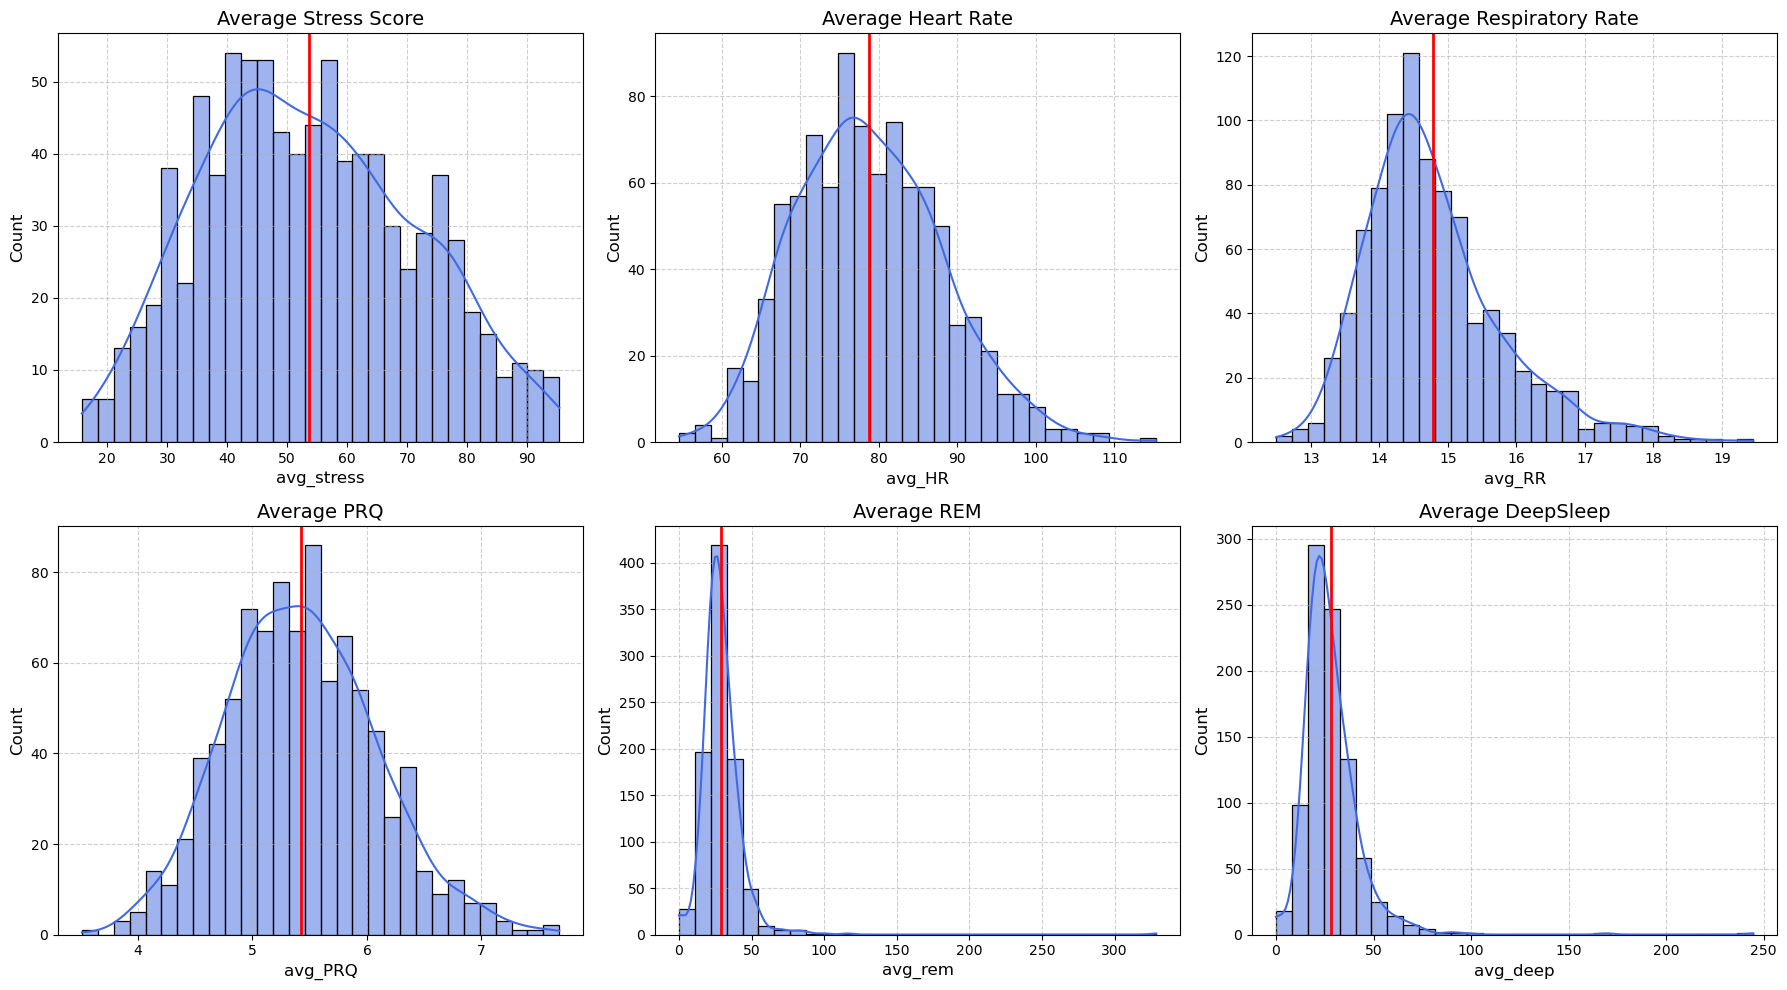

In [106]:
# Run Plot Function
summary_file = "extracted_data/fitbit_data.csv"
plot_distributions(summary_file)

Correlation coefficient between avg_deep and avg_stress: 0.43


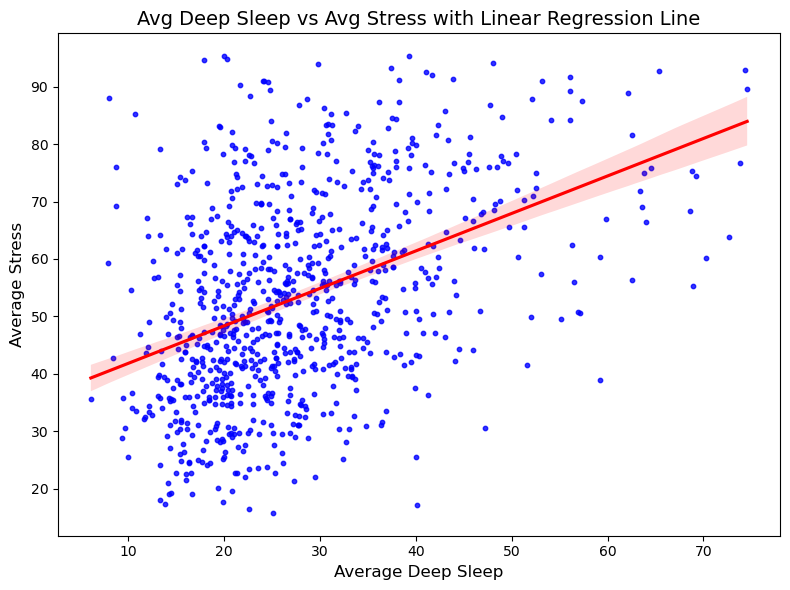

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

# Load the CSV file into a DataFrame
df = pd.read_csv("extracted_data/fitbit_data.csv")

# Filter out rows where 'avg_deep' is greater than 100 or equal to 0, and drop NaN values
df_filtered = df[(df['avg_deep'] <= 80) & (df['avg_deep'] > 0)].dropna(subset=['avg_stress', 'avg_deep'])

# Calculate the Pearson correlation coefficient
corr_coefficient, _ = pearsonr(df_filtered['avg_deep'], df_filtered['avg_stress'])

# Print the correlation coefficient
print(f"Correlation coefficient between avg_deep and avg_stress: {corr_coefficient:.2f}")

# Plot the scatter plot and linear regression line using seaborn
plt.figure(figsize=(8, 6))
sns.regplot(x='avg_deep', y='avg_stress', data=df_filtered, scatter_kws={'s':10, 'color':'blue'}, line_kws={'color':'red'})

# Customize the plot
plt.title('Avg Deep Sleep vs Avg Stress with Linear Regression Line', fontsize=14)
plt.xlabel('Average Deep Sleep', fontsize=12)
plt.ylabel('Average Stress', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


